# Introduction and Strategy Explanation

As an analyst at AQR, I have to come up with a quantitiative investment strategy. We initially thought about going with the momentum strategy, but then we decided to analyse how our strategy would do based on the market cap of the stocks in question.

We decided to take all data available in Computstat and CRSP and merge them into one dataframe and filtered the small cap stocks out of that. We then calculate the market equity and divided it into 10 deciles based on that. Since we went our investment strategy to be applicable and replicable on a large scale, we ensured that everything in the decile(2) we choose was above 300 million so that our total the total market equity of the portfolio is high and large amounts can be invested in it. We want to explore the smaller of the entire smaller cap portfolio to analyze a high growth high return portfolio.
We selected the market as our benchmark, because a strategy is only attractive if it outperforms the market comfortably, and the extra risk would not be worth it, if we cannot provide the extra return. The market is a common benchmark used to compare strategies, and we feel that is appropriate as our strategy also includes stocks from a variety of categories, but on a smaller scale.

We think our strategy will outperform the benchmark, because our strategy comprises high growth high-risk stocks so it is clear that we will generate higher returns. Historically, smaller cap stocks have performed better than larger companies in terms of annual returns. There is also less competition from institutional investors as they often overlook those stocks. However, these stocks are more volatile and more likely to go bankrupt. Therefore the question that arises is whether the return is worth the risk and we analyze whether the extra return is worth the extra risk involved. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import plotly.offline as plyo 
import cufflinks as cf 
plyo.init_notebook_mode(connected=True)  

plt.rcParams['figure.dpi'] = 300
pd.options.display.float_format = '{:,.4f}'.format

In [2]:
# import CRSP data (monthly prices and returns)
crsp = pd.read_csv(
    'crsp-2021-01-14.csv', 
    parse_dates=['date'], 
    na_values=['A', 'B', 'C'], 
    usecols=['PERMNO', 'date', 'RET', 'PRC', 'SHROUT']
)
crsp.sort_values(['PERMNO', 'date', 'RET'], inplace=True)
crsp.drop_duplicates(subset=['PERMNO', 'date'], inplace=True)


In [3]:
# import Fama-French factors
ff = pd.read_csv(
    'F-F_Research_Data_Factors.CSV',
    index_col=0,
    skiprows=3,
    nrows=12*(2020 - 1927 + 1) + 6 + 1
)
ff.index = pd.to_datetime(ff.index, format='%Y%m') + pd.offsets.MonthEnd(0)
ff /= 100


In [4]:
# import Compustat data (fundamentals)
compustat = pd.read_csv('compustat-2021-01-14.csv', parse_dates=['datadate'])

compustat.sort_values(['LPERMNO', 'datadate', 'fyear'], inplace=True)
compustat.drop_duplicates(subset=['LPERMNO', 'datadate'], inplace=True, keep='last')

In [5]:
crsp['date'] += pd.offsets.MonthEnd(0)
compustat['datadate'] += pd.offsets.MonthEnd(0)

In [6]:
# Calculating the ME from the CRSP data
crsp['ME'] = np.abs(crsp['PRC']) * crsp['SHROUT'] / 1000
temp = crsp[['PERMNO', 'date', 'ME']].copy()
temp['date'] += pd.offsets.MonthEnd(12)

crsp = pd.merge(
    left=crsp,
    right=temp,
    on=['PERMNO', 'date'],
    suffixes=['', '_lag12']
)

In [7]:
crsp.sort_values(['date', 'PERMNO'], inplace=True)
compustat.sort_values(['datadate', 'LPERMNO'], inplace=True)

In [8]:
# Merging the 2 data sets into a new data frame
finaldata = pd.merge_asof(crsp, compustat, left_on='date', right_on='datadate', left_by='PERMNO', right_by='LPERMNO')

In [9]:
finaldata.loc[finaldata.groupby('PERMNO').head(1).index, 'RET'] = np.nan
finaldata['RET12'] = np.exp(np.log(1 + finaldata['RET']).rolling(12).sum()) - 1

In [10]:
#Filtering out anything before 1965
finaldata = finaldata[(finaldata['date'] > '1964-12-31')]
finaldata = finaldata[(finaldata['ME'] > 300)]
finaldata = finaldata[(finaldata['ME'] < 2001)]
finaldata

,PERMNO,date,PRC,RET,SHROUT,ME,ME_lag12,GVKEY,LPERMNO,LPERMCO,...,ceq,csho,dlc,dltt,dvc,ni,oibdp,costat,prcc_f,RET12
415169,10137,1965-01-31,29.3750,0.0398,"18,677.0000",548.6369,471.5690,"1,279.0000","10,137.0000","20,045.0000",...,203.0940,18.6770,0.0000,322.2310,18.9570,29.3360,93.6060,I,28.2500,-0.1692
415170,10145,1965-01-31,57.0000,0.1041,"26,296.0000","1,498.8720","1,408.1040","1,300.0000","10,145.0000","22,168.0000",...,659.4880,26.2970,1.6000,227.0980,47.3500,81.0100,219.8800,A,51.6249,-0.0336
415172,10161,1965-01-31,45.2500,0.0554,"14,454.0000",654.0435,540.8217,"1,365.0000","10,161.0000","20,063.0000",...,270.5600,14.4540,1.9000,71.4000,23.0700,45.6000,58.9600,I,42.8749,0.2268
415176,10225,1965-01-31,35.6250,0.0755,"25,999.0000",926.2144,743.8215,"1,408.0000","10,225.0000","20,067.0000",...,585.6880,25.9990,32.1000,69.1340,41.7200,73.1950,155.9500,I,33.1200,1.1139
415178,10241,1965-01-31,44.0000,0.0349,"16,309.0000",717.5960,671.4980,"1,414.0000","10,241.0000","22,177.0000",...,525.5650,16.3100,4.4000,220.6000,32.5400,46.9000,142.2600,A,43.0000,0.9737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4209437,93397,2019-12-31,19.2300,-0.0223,"17,773.0000",341.7748,347.3057,"29,962.0000","93,397.0000","53,423.0000",...,206.2660,17.7560,3.0230,105.8920,5.3310,-5.9430,2.7040,A,18.9200,0.4239
4209439,93415,2019-12-31,11.2600,0.1249,"70,415.0000",792.8729,733.0202,"185,156.0000","93,415.0000","53,433.0000",...,nan,70.4150,nan,nan,nan,nan,nan,A,11.2600,0.0751
4209442,93420,2019-12-31,3.2600,0.3932,"321,311.0000","1,047.4739","1,760.9400","184,442.0000","93,420.0000","53,438.0000",...,"3,636.1380",321.2310,8.5950,"2,733.4460",0.0000,-128.2430,975.7100,A,3.2600,0.5928
4209444,93422,2019-12-31,4.5000,0.3761,"237,792.0000","1,070.0640","1,333.0207","154,357.0000","93,422.0000","53,439.0000",...,"2,660.6000",237.7000,36.3000,"2,060.4000",9.6000,-97.3000,742.0000,A,4.5000,1.0956


In [11]:
# the easiest and safest way to lag returns is to make a copy, increase the date, and merge
# here we make a .copy() to avoid changing finaldata
temp = finaldata[['PERMNO', 'date', 'RET12']].copy()
temp['date'] += pd.offsets.MonthEnd(2)

In [12]:
# merge the previous 12-month returns to crsp with _lag2 suffix
merged = pd.merge(
    left=finaldata,
    right=temp.dropna(),
    how='inner',
    on=['PERMNO', 'date'],
    suffixes=['', '_lag2']
)

In [13]:
# to generate market-cap weights (value weights)...
# we need market cap at the beginning of the month
merged['ME'] = np.abs(merged['PRC']) * merged['SHROUT']

In [14]:
merged['ME'].describe()

count     580,759.0000
mean      820,241.2468
std       432,002.7065
min       300,001.5000
25%       464,894.3750
50%       693,848.0000
75%     1,088,843.4500
max     2,000,992.0000
Name: ME, dtype: float64

In [15]:
temp = merged[['PERMNO', 'date', 'ME']].copy()
temp['date'] += pd.offsets.MonthEnd(1)

merged = pd.merge(
    left=merged,
    right=temp.dropna(),
    how='inner',
    on=['PERMNO', 'date'],
    suffixes=['', '_lag1']
)

In [16]:
# order market cap of stocks 
merged['me_q10'] = merged.groupby('date')['ME_lag1'].transform(lambda x : pd.qcut(x, 10, labels=False)) + 1

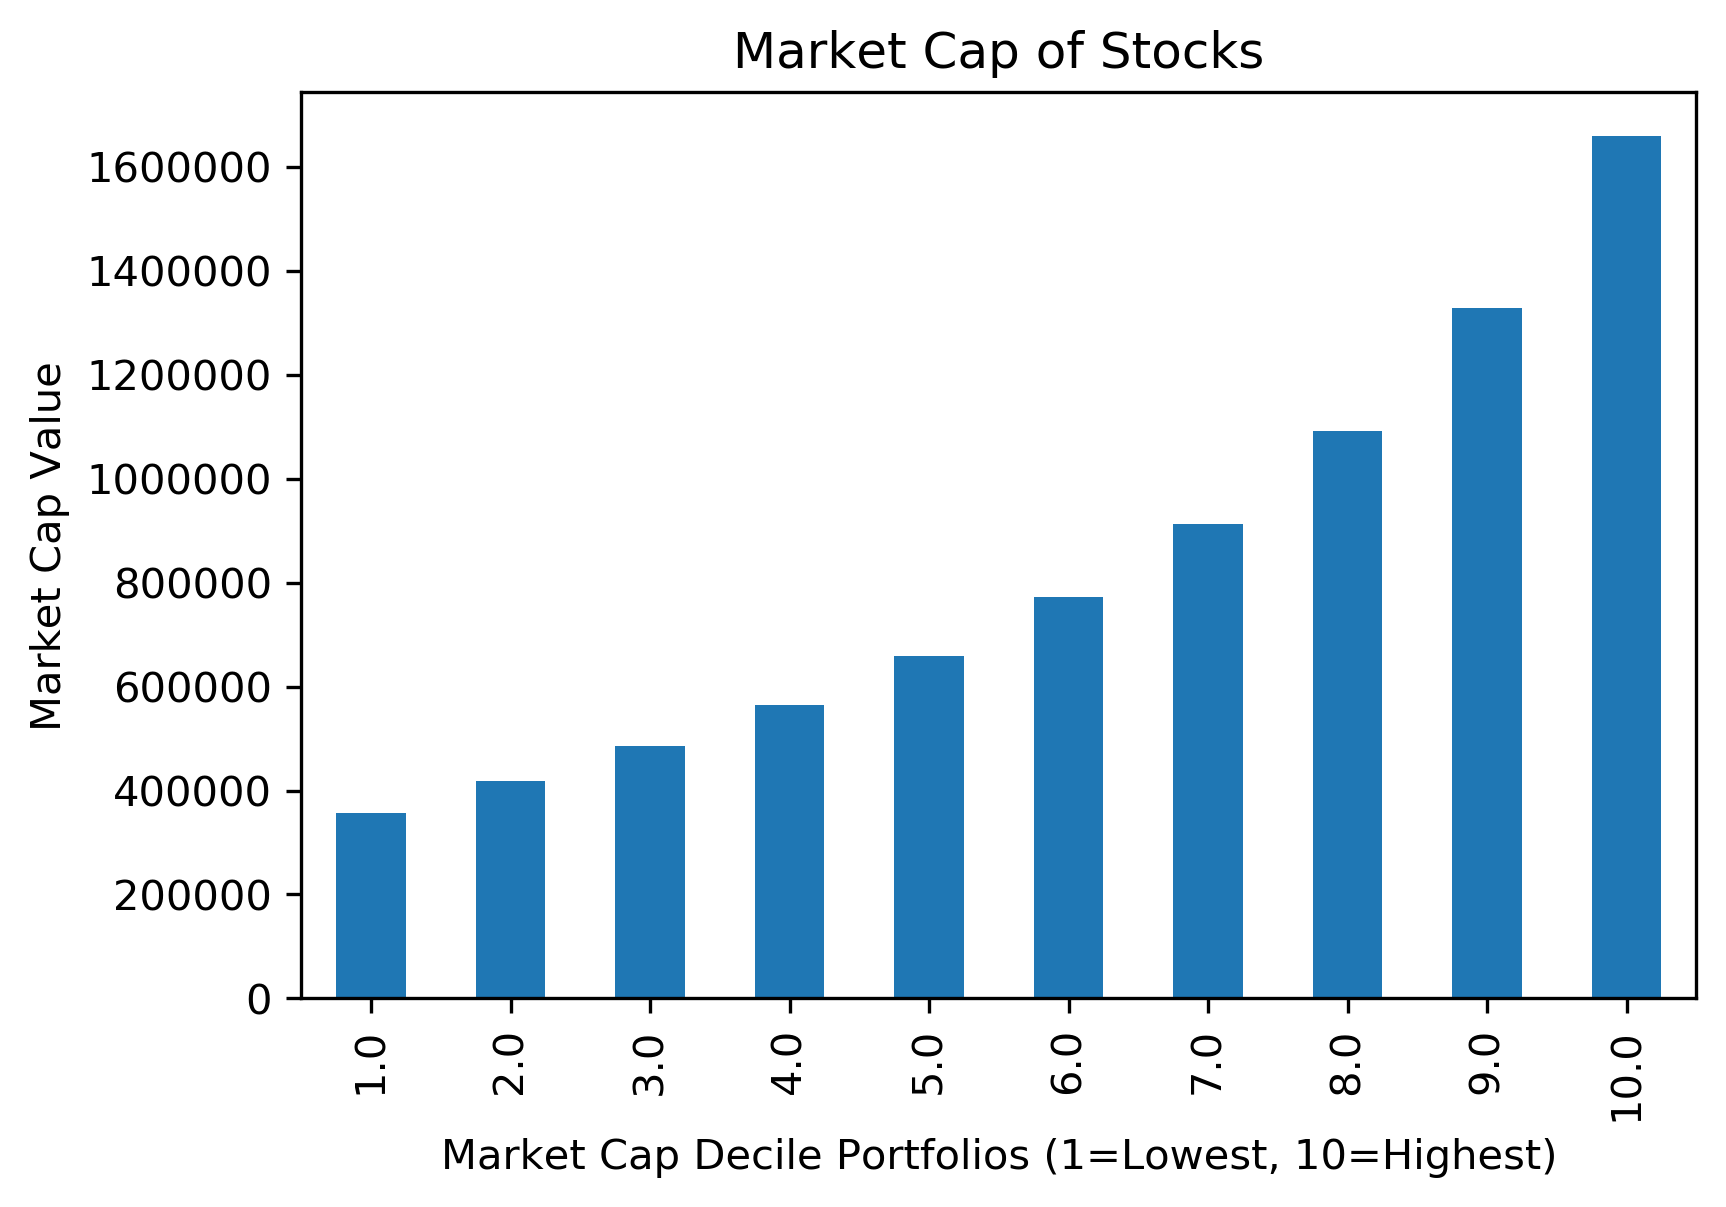

In [17]:
#Plotting the market cap of stocks by decile
merged.groupby('me_q10')['ME'].mean().plot(kind='bar') 
plt.xlabel('Market Cap Decile Portfolios (1=Lowest, 10=Highest)')
plt.ylabel('Market Cap Value')
plt.title('Market Cap of Stocks')
plt.show()

Text(0.5, 1.0, 'Returns')

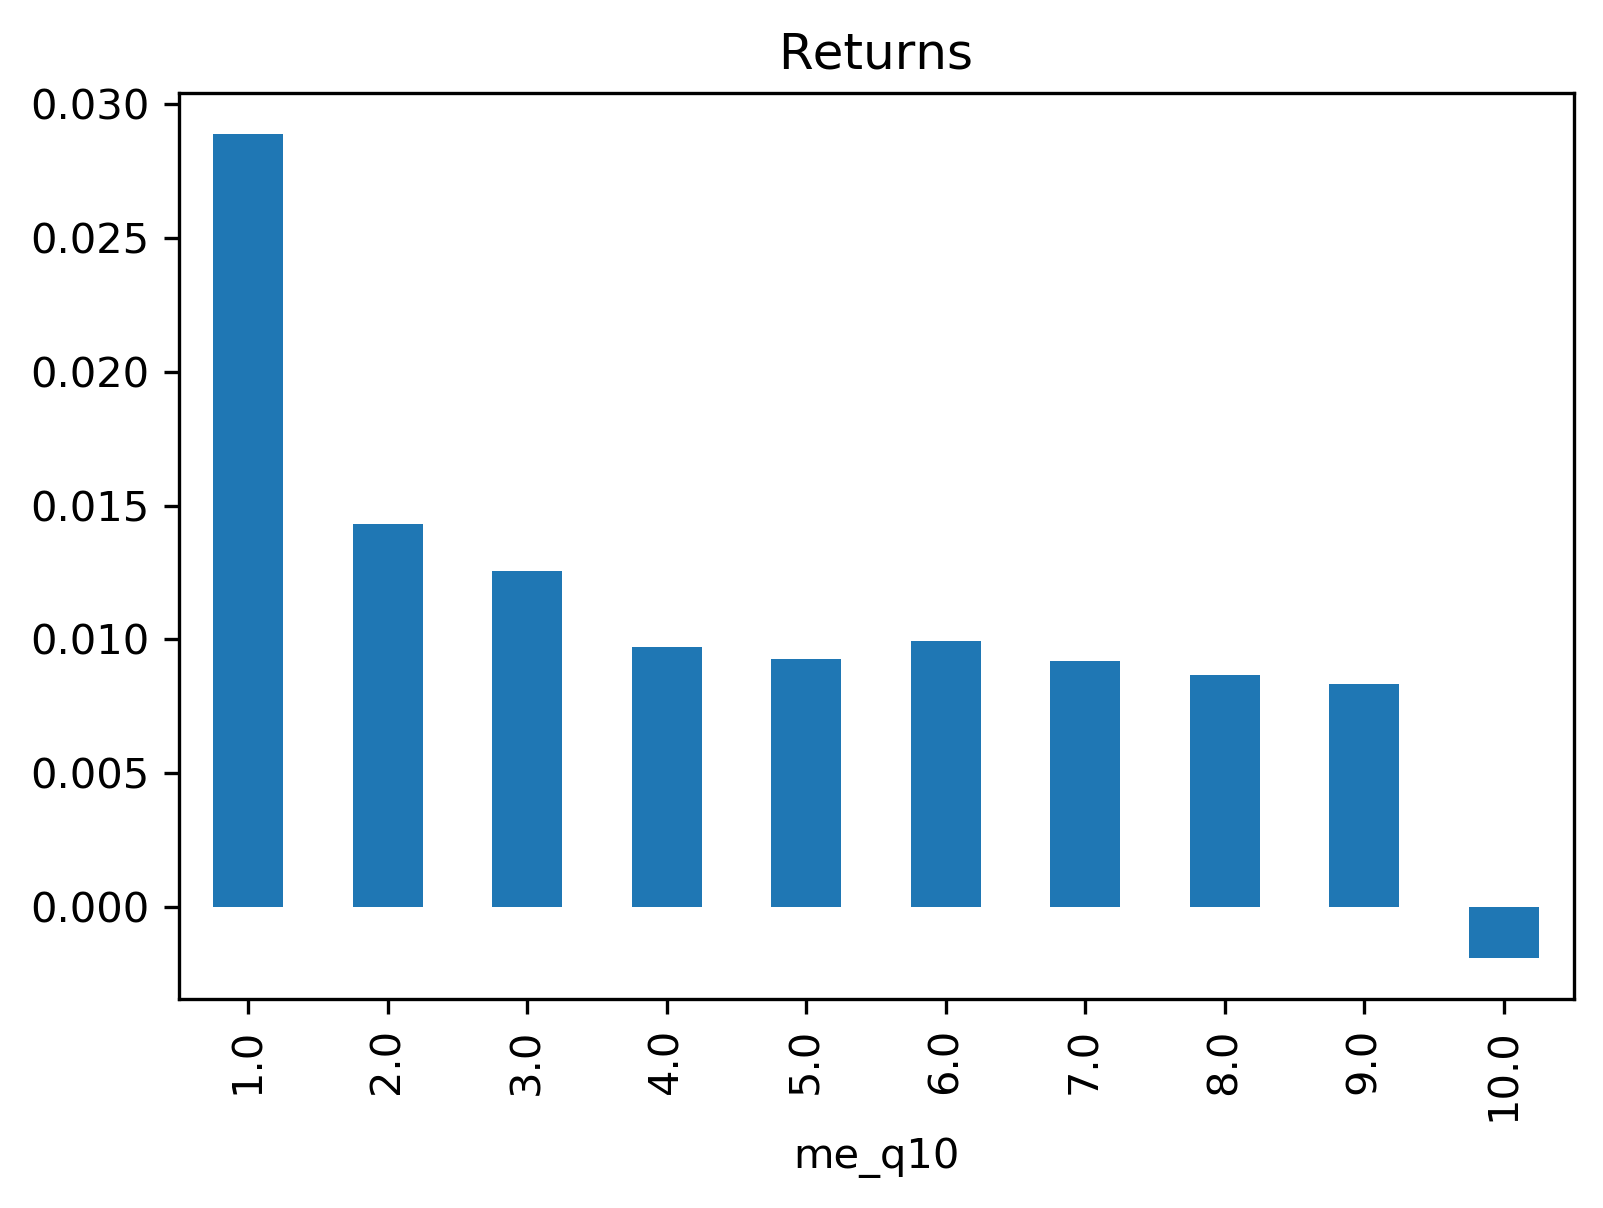

In [18]:
#Plotting the market cap of stocks by decile
merged.groupby('me_q10')['RET'].mean().plot(kind='bar') 
plt.title('Returns')

Text(0.5, 1.0, 'January Returns')

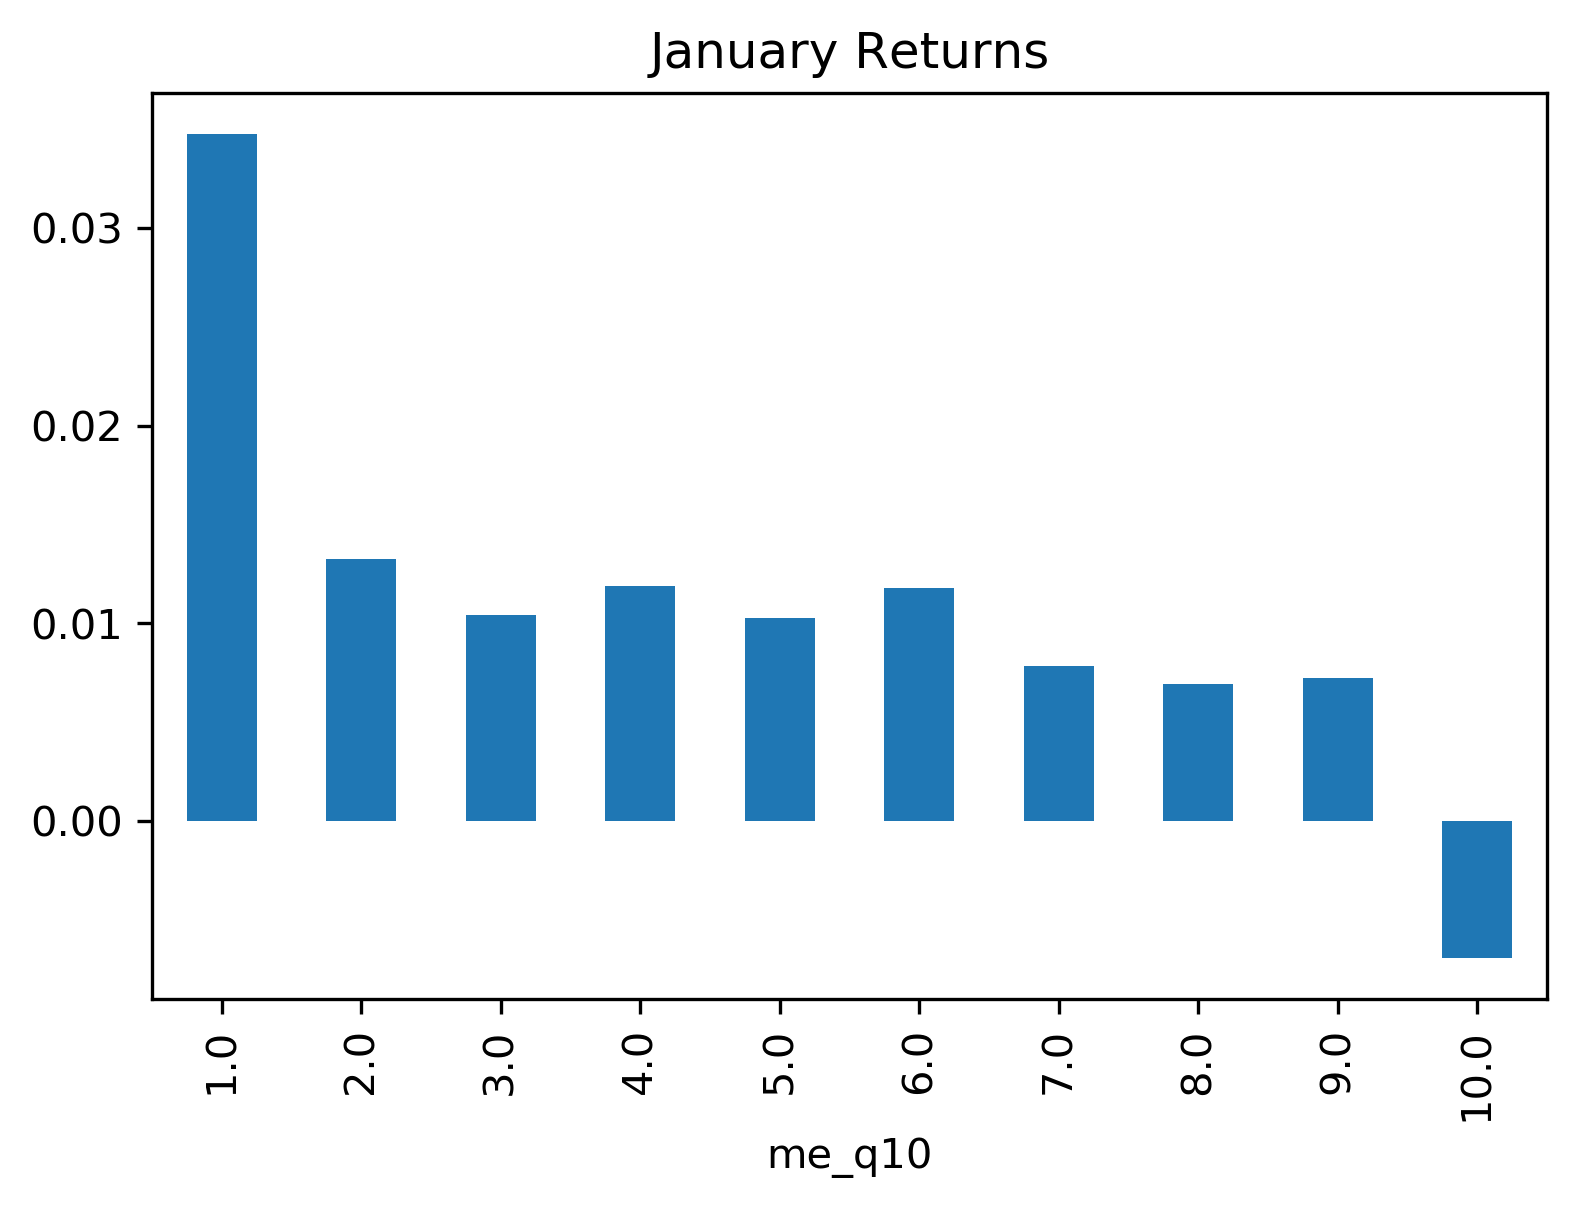

In [19]:
#Plotting the January Returns to show the anomaly in trend and data
merged[merged['date'].dt.month == 1].groupby('me_q10')['RET'].mean().plot(kind='bar') 
plt.title('January Returns')

Text(0.5, 1.0, 'Rest of Year Returns')

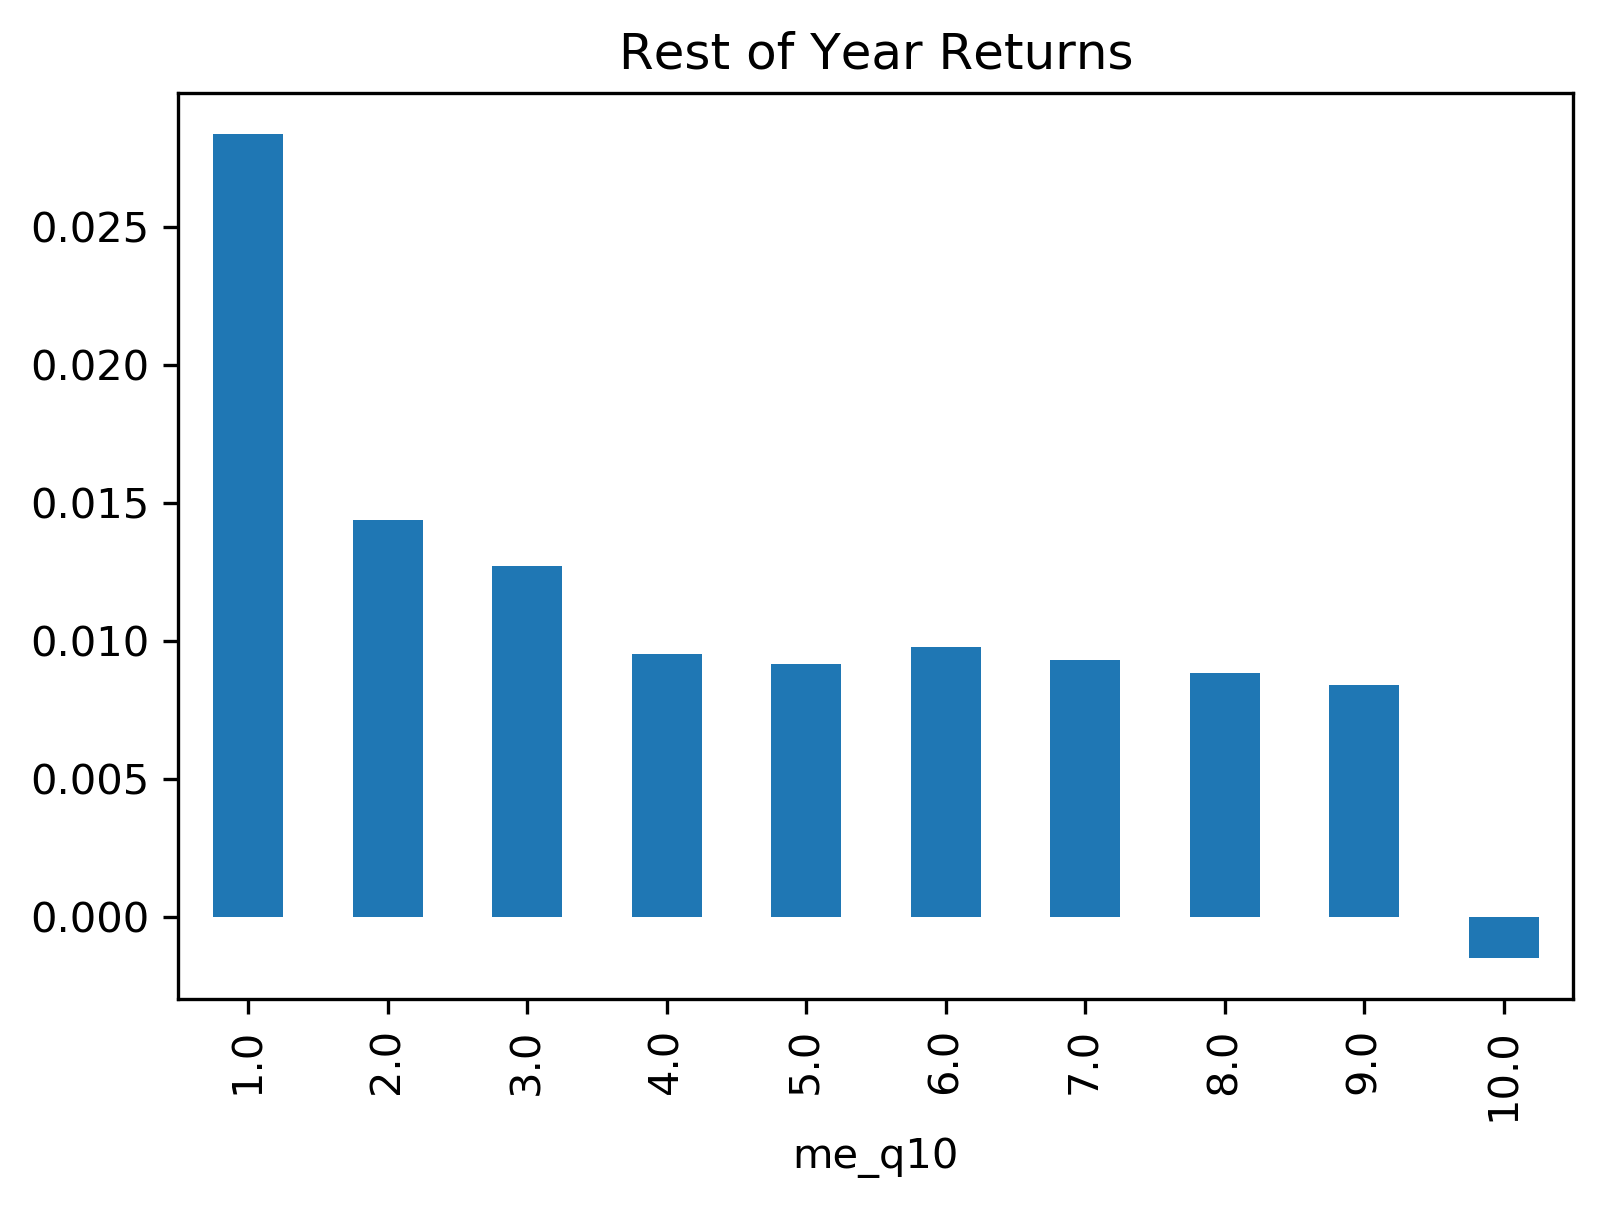

In [20]:
# Plotting the returns for the rest of the year
merged[merged['date'].dt.month != 1].groupby('me_q10')['RET'].mean().plot(kind='bar') 
plt.title('Rest of Year Returns')

In [21]:
# Dropping na values
merged.dropna(subset=['me_q10', 'RET'], inplace=True)
merged

,PERMNO,date,PRC,RET,SHROUT,ME,ME_lag12,GVKEY,LPERMNO,LPERMCO,...,dltt,dvc,ni,oibdp,costat,prcc_f,RET12,RET12_lag2,ME_lag1,me_q10
0,10137,1965-04-30,29.5000,-0.0126,"18,677.0000","550,971.5000",479.7398,"1,279.0000","10,137.0000","20,045.0000",...,322.2310,18.9570,29.3360,93.6060,I,28.2500,0.9012,2.2328,"557,975.3750",5.0000
1,10145,1965-04-30,53.8750,-0.0315,"26,822.0000","1,445,035.2500","1,414.6230","1,300.0000","10,145.0000","22,168.0000",...,227.0980,47.3500,81.0100,219.8800,A,51.6249,0.4844,1.5048,"1,491,973.7500",10.0000
2,10161,1965-04-30,49.1250,0.0480,"14,454.0000","710,052.7500",639.6430,"1,365.0000","10,161.0000","20,063.0000",...,71.4000,23.0700,45.6000,58.9600,I,42.8749,0.6590,1.4946,"677,531.2500",6.0000
3,10225,1965-04-30,37.5000,0.0526,"25,999.0000","974,962.5000",867.7917,"1,408.0000","10,225.0000","20,067.0000",...,69.1340,41.7200,73.1950,155.9500,I,33.1200,0.4043,0.3140,"926,214.3750",8.0000
4,10241,1965-04-30,47.7500,0.0904,"16,309.0000","778,754.7500",708.3485,"1,414.0000","10,241.0000","22,177.0000",...,220.6000,32.5400,46.9000,142.2600,A,43.0000,0.3749,0.4533,"721,673.2500",6.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511772,93397,2019-12-31,19.2300,-0.0223,"17,773.0000","341,774.7900",347.3057,"29,962.0000","93,397.0000","53,423.0000",...,105.8920,5.3310,-5.9430,2.7040,A,18.9200,0.4239,0.1467,"350,927.8850",1.0000
511773,93415,2019-12-31,11.2600,0.1249,"70,415.0000","792,872.9000",733.0202,"185,156.0000","93,415.0000","53,433.0000",...,nan,nan,nan,nan,A,11.2600,0.0751,0.0742,"704,854.1500",5.0000
511774,93420,2019-12-31,3.2600,0.3932,"321,311.0000","1,047,473.8600","1,760.9400","184,442.0000","93,420.0000","53,438.0000",...,"2,733.4460",0.0000,-128.2430,975.7100,A,3.2600,0.5928,-0.1749,"751,867.7400",5.0000
511775,93422,2019-12-31,4.5000,0.3761,"237,792.0000","1,070,064.0000","1,333.0207","154,357.0000","93,422.0000","53,439.0000",...,"2,060.4000",9.6000,-97.3000,742.0000,A,4.5000,1.0956,-0.3185,"777,579.8400",6.0000


In [22]:
# to calulate equal-weighted returns
# calculate the (unweighted) mean of RET
long = merged.groupby(['date', 'me_q10'])[['RET']].mean()
long.rename(columns={'RET': 'RET_EW'}, inplace=True)
long

RET_EW
date       me_q10         
1965-04-30 1.0000   0.0453
           2.0000   0.0215
           3.0000   0.0311
           4.0000   0.0241
           5.0000   0.0253
...                    ...
2019-12-31 6.0000   0.0553
           7.0000   0.0397
           8.0000   0.0311
           9.0000   0.0319
           10.0000  0.0076

[6550 rows x 1 columns]

In [23]:
# to calculate value-weighted portfolio returns...
# calculate the weighted mean of RET where weights are ME_lag1
long['RET_VW'] = merged.groupby(['date', 'me_q10']).apply(lambda x : np.average(x['RET'], weights=x['ME_lag1']))
long

RET_EW  RET_VW
date       me_q10                 
1965-04-30 1.0000   0.0453  0.0449
           2.0000   0.0215  0.0208
           3.0000   0.0311  0.0310
           4.0000   0.0241  0.0240
           5.0000   0.0253  0.0253
...                    ...     ...
2019-12-31 6.0000   0.0553  0.0558
           7.0000   0.0397  0.0392
           8.0000   0.0311  0.0311
           9.0000   0.0319  0.0321
           10.0000  0.0076  0.0066

[6550 rows x 2 columns]

In [24]:
# Unstacking the data
wide = long.unstack()
wide.columns = [col[0] + '_' + str(int(col[1])) for col in wide.columns.values]
wide

,RET_EW_1,RET_EW_2,RET_EW_3,RET_EW_4,RET_EW_5,RET_EW_6,RET_EW_7,RET_EW_8,RET_EW_9,RET_EW_10,RET_VW_1,RET_VW_2,RET_VW_3,RET_VW_4,RET_VW_5,RET_VW_6,RET_VW_7,RET_VW_8,RET_VW_9,RET_VW_10
date,,,,,,,,,,,,,,,,,,,,
1965-04-30,0.0453,0.0215,0.0311,0.0241,0.0253,0.0246,0.0290,0.0238,0.0215,0.0208,0.0449,0.0208,0.0310,0.0240,0.0253,0.0241,0.0282,0.0236,0.0222,0.0202
1965-05-31,-0.0047,0.0064,-0.0097,-0.0135,-0.0011,-0.0062,-0.0155,0.0010,-0.0098,-0.0009,-0.0046,0.0054,-0.0096,-0.0133,-0.0010,-0.0055,-0.0155,0.0008,-0.0094,-0.0014
1965-06-30,-0.0577,-0.0705,-0.0698,-0.0501,-0.0491,-0.0594,-0.0447,-0.0513,-0.0445,-0.0548,-0.0591,-0.0709,-0.0700,-0.0500,-0.0496,-0.0588,-0.0446,-0.0521,-0.0441,-0.0537
1965-07-31,0.0624,0.0347,0.0241,0.0076,0.0545,0.0111,-0.0045,0.0179,0.0224,0.0053,0.0615,0.0348,0.0242,0.0076,0.0536,0.0112,-0.0042,0.0183,0.0222,0.0055
1965-08-31,0.0493,0.0351,0.0340,0.0354,0.0351,0.0439,0.0291,0.0319,0.0372,0.0310,0.0496,0.0349,0.0337,0.0355,0.0355,0.0442,0.0291,0.0319,0.0367,0.0332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-31,-0.0185,-0.0372,-0.0381,-0.0431,-0.0406,-0.0536,-0.0447,-0.0519,-0.0541,-0.0458,-0.0191,-0.0374,-0.0379,-0.0439,-0.0401,-0.0534,-0.0458,-0.0522,-0.0544,-0.0456
2019-09-30,0.0364,0.0356,0.0448,0.0338,0.0303,0.0272,0.0266,0.0237,0.0254,0.0092,0.0365,0.0351,0.0454,0.0343,0.0305,0.0273,0.0263,0.0239,0.0254,0.0080
2019-10-31,0.0330,0.0240,0.0178,0.0254,0.0046,0.0118,0.0122,0.0194,0.0312,0.0129,0.0331,0.0239,0.0183,0.0249,0.0050,0.0116,0.0113,0.0195,0.0314,0.0123


In [25]:
# equal weighted and value weighted portfolios
# We choose the 8th Decile
wide['port'] = wide['RET_EW_2'] 
wide['port_VW'] = wide['RET_VW_2'] 

In [26]:
# add the Fama-French factors and the RF rates
wide = wide.join(ff)
wide.rename(columns={'Mkt-RF': 'Mkt_RF'}, inplace=True)

In [27]:
# Assigning the value-weighted return for further calculation
wide['Mkt'] = wide['Mkt_RF'] + wide['RF']
wide['port_rf'] = wide['RET_VW_2'] - wide['RF']

# Characteristics of Stocks in Strategy

Our strategy is not zero investment, as we are a long only strategy, so we are summarising our long portfolio below.

In [28]:
# Defining our stock portfolio which is the 2nd decile
portfolio = merged[merged['me_q10'] == 2]
portfolio

,PERMNO,date,PRC,RET,SHROUT,ME,ME_lag12,GVKEY,LPERMNO,LPERMCO,...,dltt,dvc,ni,oibdp,costat,prcc_f,RET12,RET12_lag2,ME_lag1,me_q10
14,11367,1965-04-30,39.5000,0.0640,"10,641.0000","420,319.5000",431.2750,nan,nan,nan,...,nan,nan,nan,nan,NaN,nan,nan,0.2464,"395,047.1250",2.0000
22,12052,1965-04-30,42.2500,0.1342,"10,015.0000","423,133.7500",256.1731,"5,046.0000","12,052.0000","20,791.0000",...,92.8000,0.0000,42.6100,112.0100,A,35.0000,0.7661,-0.2559,"373,058.7500",2.0000
39,13354,1965-04-30,33.1250,0.1229,"12,520.0000","414,725.0000",342.4886,"7,724.0000","13,354.0000","21,473.0000",...,163.6000,14.8700,27.1300,70.0100,I,26.5000,0.4411,0.2994,"369,340.0000",2.0000
40,13434,1965-04-30,57.3750,0.0177,"6,633.0000","380,568.3750",212.7125,nan,nan,nan,...,nan,nan,nan,nan,NaN,nan,0.3554,0.3127,"373,935.3750",2.0000
53,14277,1965-04-30,76.2500,0.0033,"5,150.0000","392,687.5000",329.4489,"9,465.0000","14,277.0000","21,576.0000",...,12.6000,5.9700,24.6100,66.2200,A,70.9998,0.6431,0.1428,"391,400.0000",2.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511730,93065,2019-12-31,14.2700,0.0778,"28,915.0000","412,617.0500",410.4483,"180,229.0000","93,065.0000","53,234.0000",...,297.9130,0.0000,6.0600,67.4310,A,14.2700,0.5623,0.2302,"382,834.6000",2.0000
511741,93128,2019-12-31,15.7500,0.0281,"29,014.0000","456,970.5000",379.3629,"183,797.0000","93,128.0000","53,282.0000",...,529.5400,0.0000,24.6310,-226.9740,A,15.7500,-0.2593,0.2756,"444,494.4800",2.0000
511751,93260,2019-12-31,124.0900,0.0455,"3,600.0000","446,724.0000",445.6875,nan,nan,nan,...,nan,nan,nan,nan,NaN,nan,nan,0.3267,"428,220.0000",2.0000
511755,93272,2019-12-31,8.0000,0.0323,"55,489.0000","443,912.0000",518.0175,"183,903.0000","93,272.0000","53,353.0000",...,15.2930,0.0000,-17.6940,-2.6110,A,8.0000,0.2623,0.7228,"430,039.7500",2.0000


## Characteristics of Concern

The January effect is a quirk in the market that occurs in the month of January and has to do with a perceived increase in stock prices during this time. This effect is due to investors partaking in tax-loss harvesting to offset realized capital gains by enaging in stock sell-offs. This effect is amplified when dealing with small cap stocks which can be seen below.

In [29]:
portfolio_jan = portfolio[portfolio['date'].dt.month == 1]
#[wide['date'].dt.month == 1]['port_VW'].mean().plot(kind='bar') 
#plt.title('January Returns')
portfolio_jan
portfolio_jan['RET12'].describe()

count   3,816.0000
mean        1.0830
std         8.9491
min        -0.9672
25%        -0.2326
50%         0.2238
75%         1.0750
max       439.8924
Name: RET12, dtype: float64

In [30]:
portfolio_rest = portfolio[portfolio['date'].dt.month != 1]
portfolio_rest
portfolio_rest['RET12'].describe()

count   43,264.0000
mean         0.2662
std          1.2080
min         -0.9989
25%         -0.3155
50%          0.0419
75%          0.5166
max         54.4975
Name: RET12, dtype: float64

## Characteristics

### Market Capitalization

This tells us more about our stock portfolio and our market range. The range of market caps for our portfolio is from 300M to 1.75B market cap. This reflects that our strategy is capable of handling big investments because there are no micro companies involved and even if an institustional investor were to spread 100M in our portfolio, they would not end up owing any companies.

In [31]:
portfolio['Market Cap'] = portfolio['ME'] * 1000
print('Market Capitalization Portfolio Description')
portfolio['Market Cap'].describe()

Market Capitalization Portfolio Description


count          51,142.0000
mean      417,445,947.3868
std        55,790,454.9904
min       300,066,000.0000
25%       384,699,375.0000
50%       412,031,300.0000
75%       442,220,248.7500
max     1,764,311,670.0000
Name: Market Cap, dtype: float64

### Leverage

In [32]:
## Leverage Ratio : Total Debt / Total Equity
portfolio['leverage'] = (portfolio['dlc'] + portfolio['dltt'])/(portfolio['csho'] * portfolio['prcc_f'])
portfolio['leverage'] = portfolio['leverage'].dropna()
portfolio['leverage'].describe()


count   40,659.0000
mean         1.0599
std         67.3887
min          0.0000
25%          0.0333
50%          0.2702
75%          0.7740
max     13,582.3063
Name: leverage, dtype: float64

The debt to equity ratio measures a company's financial leverage. The general consensus is that it should not be over 2, with under 1 considered ideal. Half of the stocks in this porfolio have a ratio of under .3, while 75% half a ratio under .77, with an average of 1. This means that overall the portfolio is not a high risk portfolio, although it may be more leveraged than the average portfolio.

### Profitability

In [33]:
## Return on Asset:
portfolio['roa'] = portfolio['oibdp']/portfolio['at']
portfolio['roa'].describe()

count   39,729.0000
mean         0.1245
std          1.3260
min         -8.1406
25%          0.0411
50%          0.1106
75%          0.1680
max        125.2106
Name: roa, dtype: float64

The return on asset is an indicator of how profitable a company is relative to its total assets. ROAs over 5% are generally considered good and over 20% excellent. The average of this portfolio is 12%, which is good as it exeeds the 5%.

### Price/Earnings

In [34]:
## Price/Earnings
portfolio['p_e'] = (portfolio['prcc_f'] * portfolio['csho'])/portfolio['ni']
portfolio['p_e'].describe()


count    41,028.0000
mean             inf
std              nan
min     -32,193.9625
25%           6.3510
50%          13.4896
75%          21.3262
max              inf
Name: p_e, dtype: float64

A higher P/E ratio shows that investors are willing to pay a higher share price today because of growth expectations in the future. The average P/E for the S&P 500 has historically ranged from 13 to 15. Half of the stocks have a P/E ratio of under 14, while another 25% fall between 14 and 22. This portfolio generally exceeds the S&P500 in terms of P/E.

### Price/Book

In [35]:
## Price/Book
portfolio['p_b'] = (np.abs(portfolio['PRC']) * portfolio['SHROUT'] / 1000) / portfolio['ceq'] / portfolio['ceq']
portfolio = portfolio[portfolio['ceq'] > 0]
portfolio['p_b'].describe()

count   40,056.0000
mean         5.3977
std        544.1135
min          0.0000
25%          0.0032
50%          0.0072
75%          0.0193
max     79,512.6169
Name: p_b, dtype: float64

There are high price/book outliers, given the high standard deviation, which makes it difficult to find a correlation between returns and price/book. Therefore this will not be considered as much as the other characteristics of the portfolio.

# Figures and Plots

## Plot 1 (Portfolio Excess Return vs Market Excess Return)

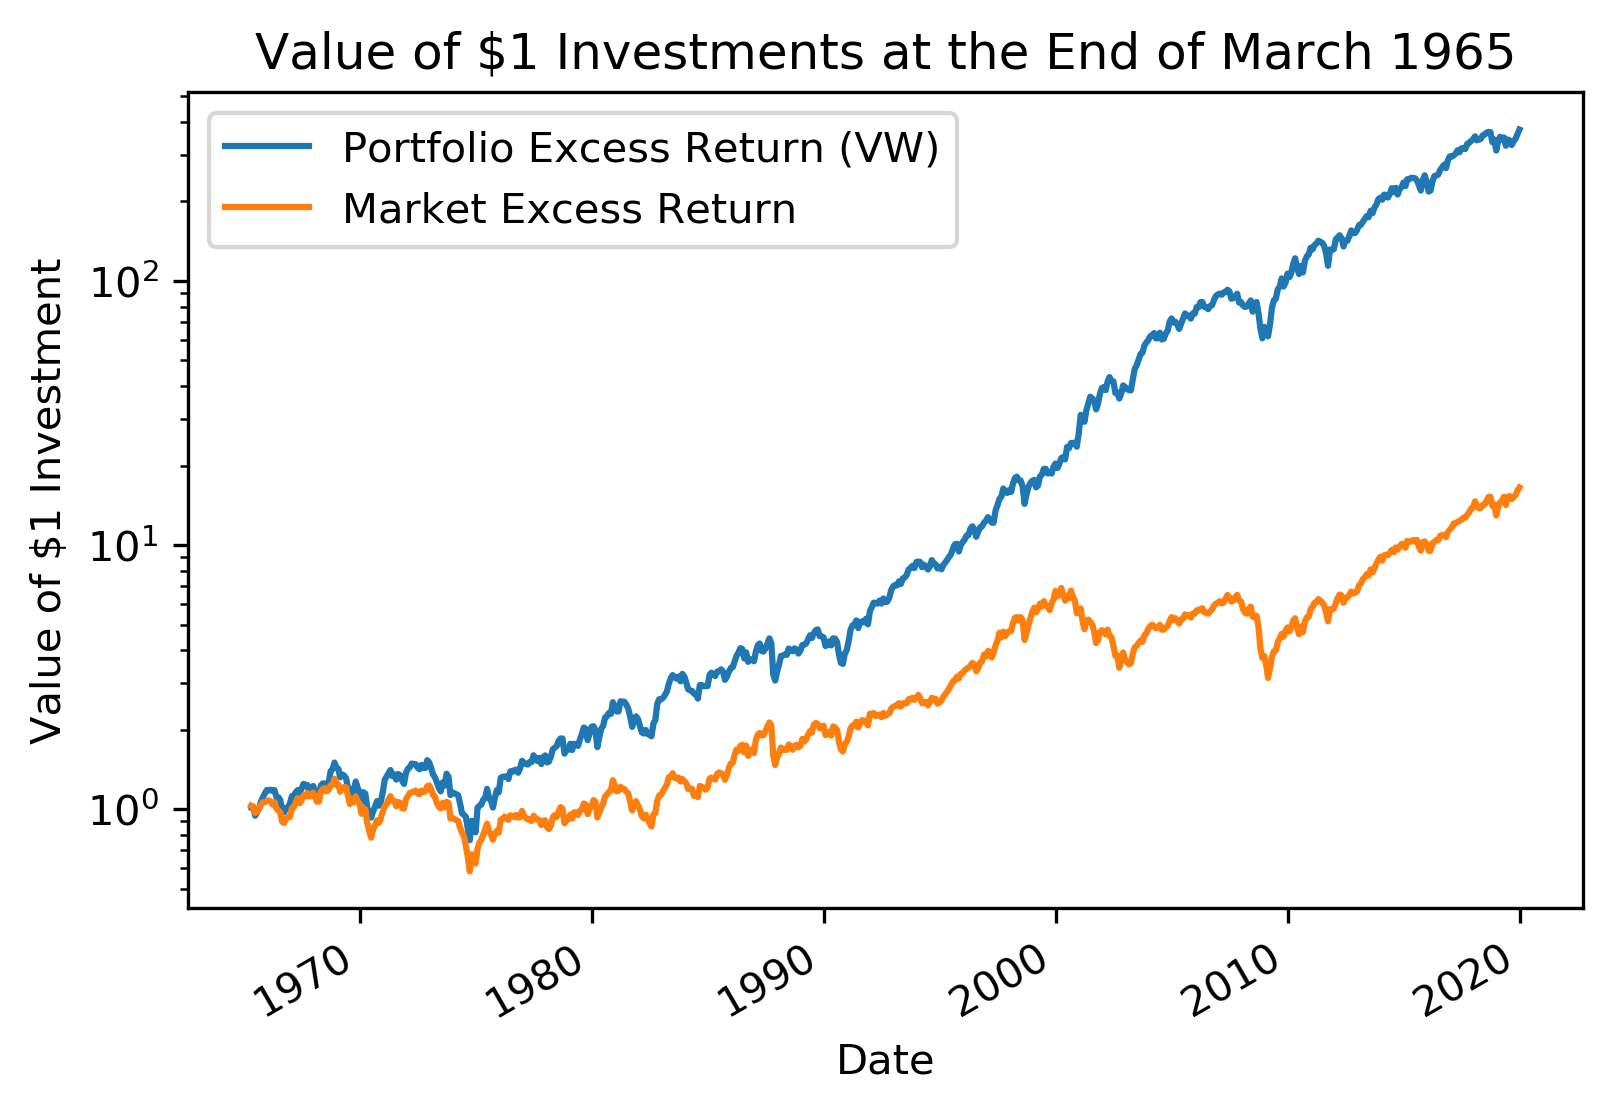

In [36]:
# Plotting Portfolio Excess Return vs Market return
wide[['port_rf', 'Mkt_RF']].add(1).cumprod().plot()
plt.legend(['Portfolio Excess Return (VW)', 'Market Excess Return'])
plt.ylabel('Value of \$1 Investment')
plt.xlabel('Date')
plt.title('Value of \$1 Investments at the End of ' + (wide.index[0] - pd.offsets.MonthEnd()).strftime(format='%B %Y'))

plt.semilogy()

plt.show()

# Plot 2 (Rolling Sharpe Ratio Comparison)

In [37]:
# Calculating the Rolling Sharpe Ratios
wide['rolling'] = wide['port_rf'].rolling(12).mean() / wide['port_rf'].rolling(12).std() * np.sqrt(12) 
wide['rolling'].dropna()

wide['Mkt_rolling'] = wide['Mkt_RF'].rolling(12).mean() / wide['Mkt_RF'].rolling(12).std() * np.sqrt(12) 
wide['Mkt_rolling'].dropna()

portfolioRolling = wide['rolling'].dropna()
mktRolling = wide['Mkt_rolling'].dropna()


zippedSharpe = {'Portfolio': portfolioRolling,'Benchmark': mktRolling}
rollingSharpeDf = pd.DataFrame(zippedSharpe)
rollingSharpeDf

,Portfolio,Benchmark
date,,
1966-03-31,1.3886,0.4973
1966-04-30,1.2996,0.4009
1966-05-31,0.6740,-0.1365
1966-06-30,1.5488,0.2982
1966-07-31,0.9843,-0.0471
...,...,...
2019-08-31,-0.4907,-0.0005
2019-09-30,-0.3007,0.0688
2019-10-31,0.2545,0.6203


In [38]:
# Plotting the calculated values
plyo.iplot(  
    rollingSharpeDf[['Portfolio','Benchmark']].iplot(asFigure=True,
                                                 title='Rolling Sharpe Ratio Comparison',  
             xTitle='Date',  
             yTitle='Sharpe Ratio',
                                                 mode={'Portfolio': 'lines+markers', 'Benchmark': 'lines+markers'},  
             symbol={'Portfolio': 'circle', 'Benchmark': 'diamond'},  
             size=3.5,  
             colors={'Portfolio': 'blue', 'Benchmark': 'red'}, ),)

The Sharpe Ratio measures an investment’s returns relative to the risk. A higher sharpe ratio is considered better as it indicates optimisation and high return relative to the risk. The rolling sharpe ratio of the strategy seems to be mostly higher than the benchmark, which is a good indication that our strategy performs well and has a more attractive risk adjusted return.

# Plot 3 (Rolling Volatility Comparison)

In [39]:
# Calculating rolling volatilities
wide['std'] = wide['port_rf'].rolling(12).std(ddof=0) * np.sqrt(12)
wide['std'].dropna()

wide['Mkt_std'] = wide['Mkt_RF'].rolling(12).std(ddof=0) * np.sqrt(12)
wide['Mkt_std'].dropna()

portfolioStd = wide['std'].dropna()
mktStd = wide['Mkt_std'].dropna()


zippedStd = {'Portfolio': portfolioStd,'Benchmark': mktStd}
rollingVolDf = pd.DataFrame(zippedStd)
rollingVolDf

,Portfolio,Benchmark
date,,
1966-03-31,0.1148,0.0853
1966-04-30,0.1149,0.0826
1966-05-31,0.1341,0.1003
1966-06-30,0.1040,0.0848
1966-07-31,0.1085,0.0855
...,...,...
2019-08-31,0.1877,0.1888
2019-09-30,0.1918,0.1893
2019-10-31,0.1742,0.1713


In [40]:
# Plotting the calculations
plyo.iplot(  
    rollingVolDf[['Portfolio','Benchmark']].iplot(asFigure=True,
                                                 title='Rolling Volatility Comparison',  
             xTitle='Date',  
             yTitle='Volatility',
                                                 mode={'Portfolio': 'lines+markers', 'Benchmark': 'lines+markers'},  
             symbol={'Portfolio': 'circle', 'Benchmark': 'diamond'},  
             size=3.5,  
             colors={'Portfolio': 'green', 'Benchmark': 'orange'}, ),)

Our porfolio is overall more volatile than the benchmark, but not by a significant amount that causes concern to investors. This is because small cap stocks are known to be more volatile and tend to riskier investments as they do not have the resouces of mid to large cap companies. The strategy is significantly more volatile during the period after the 2008 financial crisis, but becomes more in line afterwards with the benchmark.

# Plot 4 (Portfolio Values vs Benchmark Values)

In [41]:
# Calculating the portfolio values vs benchmark values
initialInvestment = 500
returnsLst = []

for i in range(len(wide['port_VW'])):
    initialInvestment *= 1 + (wide['port_VW'][i])
    returnsLst.append(initialInvestment)

initialInvestmentBench = 500
returnsLstBench = []

for i in range(len(wide['Mkt'])):
    initialInvestmentBench *= 1 + (wide['Mkt'][i])
    returnsLstBench.append(initialInvestmentBench)
    
dateLst = wide.index
    
zippedData = {'Portfolio': returnsLst,'Benchmark': returnsLstBench}
portfolio_return = pd.DataFrame(zippedData, index=dateLst)
portfolio_return

,Portfolio,Benchmark
date,,
1965-04-30,510.4161,517.1000
1965-05-31,513.1836,514.7213
1965-06-30,476.8024,488.1617
1965-07-31,493.4018,496.6557
1965-08-31,510.6297,511.8534
...,...,...
2019-08-31,"1,932,100.0924","89,174.2858"
2019-09-30,"1,999,903.8093","90,609.9918"
2019-10-31,"2,047,757.6876","92,612.4726"


In [42]:
# Plotting the calculations
plyo.iplot(  
    portfolio_return[['Portfolio','Benchmark']].iplot(asFigure=True,
                                                 title='Value of Portfolio Comparision',  
             xTitle='Date',  
             yTitle='Values',
                                                 mode={'Portfolio': 'lines+markers', 'Benchmark': 'lines+markers'},  
             symbol={'Portfolio': 'circle', 'Benchmark': 'diamond'},  
             size=2,  
             colors={'Portfolio': 'green', 'Benchmark': 'orange'}, ),)

The value of the portfolio exceeds that of the market by a large margin, ending at around 2 million. Although it has periods of losses, such as between 2007 and 2010, it recovers back fairly quickly and the overall trend is a high upward movement.

## Plot 5 (Portfolio Returns vs Benchmark Returns) (January Only)

In [43]:
# Calculating January Only Values
initialInvestment = 500
returnsLst = []
dateLst = []

for i in range(len(wide['port_VW'])):
    if (str(wide.index[i]).split('-')[1]) == '01':
        initialInvestment *= 1 + (wide['port_VW'][i])
        returnsLst.append(initialInvestment)
        dateLst.append(wide.index[i])
initialInvestmentBench = 500
returnsLstBench = []

for i in range(len(wide['Mkt'])):
    if (str(wide.index[i]).split('-')[1]) == '01':
        initialInvestmentBench *= 1 + (wide['Mkt'][i])
        returnsLstBench.append(initialInvestmentBench)

    
zippedData = {'Portfolio': returnsLst,'Benchmark': returnsLstBench}
portfolio_jan = pd.DataFrame(zippedData, index=dateLst)
portfolio_jan

,Portfolio,Benchmark
1966-01-31,500.3705,505.5000
1967-01-31,533.4784,548.8719
1968-01-31,507.2306,528.7832
1969-01-31,504.8016,524.9759
1970-01-31,470.6630,485.6028
1971-01-31,526.2417,510.9512
1972-01-31,546.9083,525.1557
1973-01-31,523.3636,510.1887
1975-01-31,652.3534,582.8396
1976-01-31,742.7908,656.4522


In [44]:
# Plotting the January values
plyo.iplot(  
    portfolio_jan[['Portfolio','Benchmark']].iplot(asFigure=True,
                                                 title='Portfolio Values vs Benchmark Values (January)',  
             xTitle='Date',  
             yTitle='Portfolio Value',
                                                 mode={'Portfolio': 'lines+markers', 'Benchmark': 'lines+markers'},  
             symbol={'Portfolio': 'circle', 'Benchmark': 'diamond'},  
             size=3.5,  
             colors={'Portfolio': 'green', 'Benchmark': 'red'}, ),)

## Plot 6 (Portfolio values  vs Benchmark values) (Non-January)

In [45]:
# Plotting the Non-January Values
initialInvestment = 500
returnsLst = []
dateLst = []

for i in range(len(wide['port_VW'])):
    if (str(wide.index[i]).split('-')[1]) != '01':
        initialInvestment *= 1 + (wide['port_VW'][i])
        returnsLst.append(initialInvestment)
        dateLst.append(wide.index[i])

initialInvestmentBench = 500
returnsLstBench = []

for i in range(len(wide['Mkt'])):
    if (str(wide.index[i]).split('-')[1]) != '01':
        initialInvestmentBench *= 1 + (wide['Mkt'][i])
        returnsLstBench.append(initialInvestmentBench)

    
zippedData = {'Portfolio': returnsLst,'Benchmark': returnsLstBench}
portfolio_remain = pd.DataFrame(zippedData, index=dateLst)
portfolio_remain

,Portfolio,Benchmark
1965-04-30,510.4161,517.1000
1965-05-31,513.1836,514.7213
1965-06-30,476.8024,488.1617
1965-07-31,493.4018,496.6557
1965-08-31,510.6297,511.8534
...,...,...
2019-08-31,"758,533.1306","43,761.4422"
2019-09-30,"785,152.5412","44,466.0014"
2019-10-31,"803,939.7418","45,448.7000"
2019-11-30,"836,919.0805","47,262.1031"


In [46]:
# Plotting the calculations
plyo.iplot(  
    portfolio_remain[['Portfolio','Benchmark']].iplot(asFigure=True,
                                                 title='Portfolio Values vs Benchmark Values (Not January)',  
             xTitle='Date',  
             yTitle='Portfolio Values',
                                                 mode={'Portfolio': 'lines+markers', 'Benchmark': 'lines+markers'},  
             symbol={'Portfolio': 'circle', 'Benchmark': 'diamond'},  
             size=2.0,  
             colors={'Portfolio': 'blue', 'Benchmark': 'magenta'}, ),)

# Calculations

## Calculation 1: Sharpe Ratio (Portfolio vs Benchmark)

In [47]:
sharpe_port = np.sqrt(12) * wide['port_rf'].mean() / wide['port_rf'].std()
sharpe_market = np.sqrt(12) * wide['Mkt_RF'].mean() / wide['Mkt_RF'].std()
print("Portfolio Sharpe Ratio : ",sharpe_port)
print("Market Sharpe Ratio : ",sharpe_market)

Portfolio Sharpe Ratio :  0.7152841141875266
Market Sharpe Ratio :  0.41203434045829024


The overall sharpe ratio is higher than the market by a good amount. As previously stated, a high sharpe ratio is preferred because it indicates a higher risk adjusted return.

## Calculation 2: Alpha and Beta (Portfolio vs Benchmark)

In [48]:
smf.ols(
    formula='port_rf ~ Mkt_RF',
    data=wide
).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                port_rf   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     2382.
Date:                Wed, 28 Apr 2021   Prob (F-statistic):          5.16e-220
Time:                        22:44:12   Log-Likelihood:                 1535.9
No. Observations:                 655   AIC:                            -3068.
Df Residuals:                     653   BIC:                            -3059.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0051      0.001      5.535      0.000       0.003       0.007
Mkt_RF         0.9959      0.020     48.801      0.000       0.956       1.036
==============================================================================
Omnibus:                      134.518   Durbin-Watson:                   1.778
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              405.167
Skew:                           0.987   Prob(JB):                     1.05e-88
Kurtosis:                       6.309   Cond. No.                         22.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [49]:
## Portfolio Beta 
corr_port_market = wide['port_rf'].corr(wide['Mkt_RF'])
sd_port = wide['port_rf'].std()
sd_market = wide['Mkt_RF'].std()
port_beta = corr_port_market * sd_port / sd_market
print("Portfolio Beta : ",port_beta)

## Jensen's Alpha
jensen_port = jensena = wide['port_VW'].mean() - (wide['RF'].mean() + (port_beta*(wide['Mkt'].mean() - wide['RF'].mean())))
jensen_bench = 0
print("Portfolio Jensen Alpha : ",jensen_port)
print("Benchmark Jensen Alpha : ",jensen_bench)

Portfolio Beta :  0.9958718040247869
Portfolio Jensen Alpha :  0.005059813388768769
Benchmark Jensen Alpha :  0


Jensen's alpha, simply referred to as alpha, is used in finance as a measure of performance indicating when a strategy has managed to outperform the market return over some period. The strategy has a significantly positive intercept or alpha, and appears to provide about .5%/month of risk adjusted return. A t >= 2 is statistically significant and the t is over 5 so we are confident of its significance. The strategy therefore offers an excess return. The beta is around 1, which means that it is about as volatile as the market. Our strategy mirrors the volatility of the market while having a higher alpha.

## Calculation 3: Sortino Ratio (Portfolio vs Benchmark)

In [50]:
wide['downside_port'] = np.where(wide['port_VW'] < 0, wide['port_VW'], 0)
sorti_port = np.sqrt(12) * wide['port_rf'].mean() / wide['downside_port'].std()
wide['downside_bench'] = np.where(wide['Mkt'] < 0, wide['Mkt'], 0)
sorti_market = np.sqrt(12) * wide['Mkt_RF'].mean() / wide['downside_bench'].std()
print("Portfolio Sortino Ratio : ",sorti_port)
print("Benchmark Sortino Ratio : ",sorti_market)

Portfolio Sortino Ratio :  1.4058299746025817
Benchmark Sortino Ratio :  0.715028684286278


The Sortino ratio is a variation of the Sharpe ratio that differentiates harmful volatility from total overall volatility by using the asset's downside deviation instead of the total standard deviation of portfolio returns. As a general rule, a Sharpe ratio with a score of one or above is considered good. Our strategy performs a lot better than the benchmark, and is also over 1, which means our strategy is earning more return per unit of bad risk it takes on. 

## Calculation 4: Treynor's Ratio (Portfolio vs Benchmark)

In [51]:
treynor_port = 12 * wide['port_rf'].mean() / port_beta
treynor_market = 12 * wide['Mkt_RF'].mean() / 1
print("Treynor Ratio of Portfolio : ",treynor_port)
print("Treynor Ratio of Market : ",treynor_market)

Treynor Ratio of Portfolio :  0.12450716444565776
Treynor Ratio of Market :  0.0635377099236641


The Treynor Ratio measures excess returns per unit of systematic risk. It is higher than that of the benchmark, which means it gives more return per unit of systematic risk.

## Calculation 5: Information Ratio

In [52]:
tracking_error = (wide['port_VW'] - wide['Mkt']).std()*np.sqrt(12)
port_return = wide['port_VW'].mean() * 12
mkt_return = wide['Mkt'].mean() * 12
inf_ratio = (port_return - mkt_return) / tracking_error
print("Information Ratio : ",inf_ratio)

Information Ratio :  0.7517823782884663


Information Ratio measures a portfolio's performance beyond the returns of a specific benchmark, which is the market portfolio, after risk is factored into the equation. A high information ratio also indicates consistency. The information ratio is considered good when it is between 0.4 and 0.6. Our information ratio is 0.75 which is phenomenal and corresponds with our high sharpe ratio.

## Calculation 6: Miller and Moglidiani Ratio

In [53]:
annualRF = wide['RF'].mean() * 12
annualport = wide['port_VW'].mean() * 12
stddevport = wide['port_VW'].std() * 12
stddevmarket = wide['Mkt'].std() * 12 
m2_ratio_port = annualRF + (((annualport - annualRF)/stddevport)*stddevmarket)
print("Miller and Moglidiani Ratio : ",m2_ratio_port)

Miller and Moglidiani Ratio :  0.15596826838279318


We can measure the M2 ratio as the difference between the portfolio's scaled excess return with that of the market, where the scaled portfolio has volatility being the same as that of the market. So what the above number means is that at benchmark risk our portfolio would generate 15.6% return, which is better than the return provided by the benchmark, which is another positive sign for our strategy

# Limitations of our Strategy

One of the main limitations in any small cap strategy is going to be the amount of public shares and the ability to locate them. A lot of brokers will not allow or simply not have the shares of lower cap stocks. While this is generally not as much of a problem with small cap than it is with micro/nano cap, it can certainly be an issue. Similarly, because of how few shares are out in public, if you are performing this strategy on a high level with a high amount of starting capital you can risk getting into these stocks and not having enough willing buyers to purchase all your shares back or the inability to buy the shares off willing sellers in the first place.

Another important aspect that can be a potential limitation is the January Effect. This effect comes into play, as expected, in the month of January and has to do with a perceived increase in stock prices during this time. This is mainly due to investors partaking in tax-loss harvesting to offset realized capital gains by enaging in stock sell-offs. This effect is amplified when dealing with small cap stocks. You can see this effect clearly in our returns graph that only shows the small cap returns in January. While this is a good thing for us in January, our gains are generally lower in other parts of the year due to this. If we were to perform this strategy from say, February to July, we would not see optimal returns as we would be skipping the month of January.

In [54]:
rollingVolDf['Portfolio'].nlargest(15)

date
1975-01-31   0.3592
1975-02-28   0.3586
1975-03-31   0.3583
1975-07-31   0.3562
1975-04-30   0.3532
1975-06-30   0.3450
1975-05-31   0.3406
1975-08-31   0.3381
1975-09-30   0.3267
2009-05-31   0.3161
2009-04-30   0.3101
1974-10-31   0.3082
2009-07-31   0.3048
2009-08-31   0.3047
2009-06-30   0.2993
Name: Portfolio, dtype: float64

In [55]:
rollingVolDf['Benchmark'].nlargest(15)

date
1987-12-31   0.2963
2009-08-31   0.2963
2009-07-31   0.2940
1975-06-30   0.2926
1975-05-31   0.2924
1975-04-30   0.2923
1975-03-31   0.2920
1975-02-28   0.2899
1987-11-30   0.2891
1975-07-31   0.2882
2009-09-30   0.2877
2009-05-31   0.2833
1975-01-31   0.2817
1987-10-31   0.2799
2009-06-30   0.2785
Name: Benchmark, dtype: float64

Another limitation is the high volatility of our strategy. Small caps, while they offer higher returns, are more volatile are they are more vulnerable to negative events. When comparing the largest 15 volatilities with the benchmark, the portfolio exceeds that of the benchmark. A high volatility can amount to large losses, as seen in the graph of portfolio values where there are noticeable losses, especially during 2007 to 2010. This corresponds to the 2008 financial crisis, which means our portfolio may not perform as well during times of high volatility. 

In [56]:
portfolio_return['Portfolio'].pct_change().nsmallest(15)

date
1987-10-31   -0.2343
1973-11-30   -0.1408
1998-08-31   -0.1366
2008-10-31   -0.1288
1980-03-31   -0.1236
1978-10-31   -0.1168
1970-04-30   -0.1080
2011-09-30   -0.1019
1990-08-31   -0.0971
2002-07-31   -0.0964
1974-08-31   -0.0932
2008-06-30   -0.0913
2008-09-30   -0.0905
2018-12-31   -0.0902
1974-09-30   -0.0866
Name: Portfolio, dtype: float64

In [57]:
portfolio_return['Benchmark'].pct_change().nsmallest(15)

date
1987-10-31   -0.2264
2008-10-31   -0.1715
1998-08-31   -0.1565
1973-11-30   -0.1219
1980-03-31   -0.1169
1978-10-31   -0.1123
1974-09-30   -0.1096
1970-04-30   -0.1050
2000-11-30   -0.1021
2002-09-30   -0.1021
2009-02-28   -0.1009
2001-02-28   -0.0967
1990-08-31   -0.0949
2018-12-31   -0.0936
2008-09-30   -0.0909
Name: Benchmark, dtype: float64

The lowest returns for the portfolio is -23.4%, while for the benchmark it is -22.6%. We noticed that many dates are in 2008, which mirrors the financial crisis. This means that it needs  more to recover porfolio losses and break even because at larger losses, the return required increases at a much faster rate. Overall, our portfolio is more volatile, which means that there is more chance for losses that wipe out small investors. However, it is reassuring that the amount of low returns for the strategy is not that much higher when compared to the lowest returns of the benchmark.

As we can see from Plot 1,4 and 5 we notice that our strategy takes some time to show results, but once it starts to show results, we notice that the strategy starts producting exponential returns. Our strategy is clearly a long only strategy that does not offer returns to the same effect in the short term. So, our strategy is applicable to investors who think they will not have any liquidity issues and need to take out the funds. The profit only lies only holding it long and it takes a little bit of time to show the astronomical returns.

Considering the fact, that we are only dealing with companies that are small cap with a mean Market Cap of around 415 million, there is always a chance that a lot of these companies get outpowered by the competition and the big players around them and go out of business so an investor's investment in these small caps would potentially go to 0.

# Conclusion

To conclude, based on our graphs and calculations, our strategy out performs our benchmark and is an attractive investment to investors. While one metric along does not signify a good investment, we calculated using multiple ratios and metrics that are designed to assess the salience of our strategy. Based on our calculations, we conclude that our strategy is an attractive investment and fairly compensates investors for their risk. 

Although there may be times of losses, such as in the mentioned period following the 2008 crisis, the portfolio rebounds quickly and has a good investment value in the long term. While it is known that small caps are more volatile than mid to large caps, our strategy is not excessively volatile or high risk. Several indications such as the debt to equity ratio, beta, and sharpe ratio point to this conclusion. Therefore we believe our quantitative investment strategy has merit and should be considered by investors.